In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

from ema_workbench import *
from ema_workbench import analysis
from ema_workbench import RealParameter, TimeSeriesOutcome, ScalarOutcome, ema_logging, perform_experiments, save_results

from ema_workbench.connectors.excel import ExcelModel

from ema_workbench.analysis.plotting_util import *
from ema_workbench.analysis.plotting import *
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
import ema_workbench.analysis.prim as prim
from ema_workbench.analysis import regional_sa
from ema_workbench.analysis import RuleInductionType

analysis.plotting_util.COLOR_LIST= [ 
    "#1c33ff","#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", "#a3ff19", "#19ffe8",
      "#e819ff", "#a5a7dd", "#565a8c", 
    "#930700",  "#2ade72"
]

##TO-DO: If e-boiler == yes, then e-boiler metrics == on 
class BuCa:
    def __init__(self, model_file, model_cases, model_start, model_length):
        self.model_file = model_file
        self.model_cases = model_cases
        self.model_start = model_start
        self.model_length = model_length
        self.df_timeseries = None
        self.df = None
        self.x = None
        self.o = None

        self.run_model()
        self.store_results()
        self.plot_pbp() 
        self.plot_npv()
        self.plot_irr()
        self.plot_ebitda()
        self.output_results()

    def run_model(self):
        # Get the current working directory
        current_directory = os.getcwd()

        # Navigate to the parent directory
        parent_directory = os.path.dirname(current_directory)

        if __name__ == "__main__":
            ema_logging.log_to_stderr(level=ema_logging.INFO)

            model = ExcelModel("BuCa", wd=parent_directory, model_file=self.model_file)
            
            model.levers = [
            CategoricalParameter("Case", (self.model_cases)),    						
            ]
            
            model.outcomes = [
                # Standard Metrics
                TimeSeriesOutcome("TIME"),
                TimeSeriesOutcome("Model_length"),
                ScalarOutcome("MODELCHECK"),
                
                # Debt Metrics
                #TimeSeriesOutcome("DSCR_Tenor"),
                # ScalarOutcome("DSCR_First5Years_Min"),
                # ScalarOutcome("ADSCR_First5Years"),
                #ScalarOutcome("ADSCR_Tenor"),
                #ScalarOutcome("LLCR"),
                #ScalarOutcome("LLCR_Min"),

                #EBITDA_Breakdown
                ScalarOutcome("Merchant_revenue"),
                ScalarOutcome("Subsidy"),
                ScalarOutcome("Grid_costs"),
                ScalarOutcome("Energy_tax"),
                ScalarOutcome("Gas_tax"),
                ScalarOutcome("EBITDA_Total"),


                # IRR Metrics
                TimeSeriesOutcome("Rolling_Equity_IRR"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
                ScalarOutcome("Project_IRR_AfterTax"),
                ScalarOutcome("Project_IRR_BeforeTax"),
                ScalarOutcome("Equity_IRR"),
                ScalarOutcome("WACC"),

                # NPV Metrics
                ScalarOutcome("Equity_NPV"),

                #E-boiler Metrics
                ScalarOutcome("CAPEX"),
                TimeSeriesOutcome("Cumulative_cash_flow"),
                ScalarOutcome("Payback_period"),

                # Operational Metrics
                # TimeSeriesOutcome("EBITDA"),
            ]  

            # name of the sheet
            model.default_sheet = "General Inputs"

            results = perform_experiments(model, 0, policies=len(self.model_cases), reporting_interval=None)
            x,o = results

            # Automate reshaping of time series outcomes
            for outcome_name, outcome_value in o.items():
                if isinstance(outcome_value, np.ndarray) and outcome_value.ndim == 3:
                    # Assuming the first dimension is the number of scenarios
                    num_scenarios = outcome_value.shape[0]
                    num_timesteps = np.prod(outcome_value.shape[1:])
                    o[outcome_name] = outcome_value.reshape((num_scenarios, num_timesteps))
                    
                    # Print dimensions for verification
                    print(f"Reshaped {outcome_name} to {o[outcome_name].shape}")

            # Print final reshaped dimensions for verification
            for outcome_name, outcome_value in o.items():
                print(f"Final dimensions of {outcome_name}: {outcome_value.shape}")

            self.x = x
            self.o = o

    def store_results(self):
        cumulative_cash_flows = self.o['Cumulative_cash_flow']

        # Create a DataFrame from the time series data
        df_timeseries = pd.DataFrame(cumulative_cash_flows).T

        df_timeseries.columns = self.x['Case'].astype(str)

        # Convert to datetime and remove timezone
        df_timeseries['datetime'] = pd.date_range(start=self.model_start, periods=self.model_length, freq='MS')

        # Define the desired order of categories
        desired_order = list(self.model_cases)

        # Ensure the columns of df_timeseries match the desired order
        df_timeseries = df_timeseries[['datetime'] + desired_order]

        self.df_timeseries = df_timeseries

        ##----------------------------------------------------------------

        scalar_outcomes = [key for key, value in self.o.items() if value.shape[1:] == ()]

        df = pd.DataFrame({key: self.o[key] for key in scalar_outcomes})
        df["Case"] = self.x['Case'].astype(str)

        # Define the desired order of categories
        desired_order = list(self.model_cases)

        # Reorder the Case column
        df['Case'] = pd.Categorical(df['Case'], categories=desired_order, ordered=True)

        # Sort the DataFrame by the new order (optional, for consistent plotting)
        df = df.sort_values('Case')

        self.df = df

    def plot_pbp(self):
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot each column in df_timeseries (excluding 'datetime')
        for column in self.df_timeseries.columns:
            if column != 'datetime':
                ax.plot(self.df_timeseries['datetime'][11:-1], self.df_timeseries[column][11:-1], label=column)

        # Plot CAPEX as a horizontal line
        capex_value = self.o["CAPEX"][0]  # Assuming CAPEX is a single number
        ax.axhline(y=capex_value, label='_nolegend_', color='black', linestyle='--', linewidth=2)

        # Add a label for the CAPEX line above the line on the right edge
        ax.text(
            self.df_timeseries['datetime'].iloc[-30],  # x-coordinate (right edge of the plot)
            capex_value+500000,                        # y-coordinate (CAPEX value)
            f'CAPEX = €{capex_value:,.0f}',    # Label text
            color='black',                      # Text color
            fontsize=10,                        # Font size
            ha='left',                          # Horizontal alignment
            va='bottom'                         # Vertical alignment
        )

        # Add labels, title, and legend
        ax.set_ylabel('Cumulative Cash Flows', fontsize=12)
        ax.legend(fontsize=10)

        # Format y-axis with thousands comma separator and euro sign
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Format x-axis to show every year
        ax.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display the year

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)
        plt.xlim(self.df_timeseries['datetime'][11], self.df_timeseries['datetime'].iloc[-1])  # Set x-axis limits

        # Add gridlines
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_npv(self):
        # Create the figure and axis
        num_cases = len(self.df)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))

        # Create a bar chart with thinner bars and updated color
        bars = plt.bar(self.df['Case'], self.df['Equity_NPV'], color='#1c33ff', width=0.4)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)

        # Format y-axis with a comma separator for thousands
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Add gridlines for y-axis
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Redraw the bars to ensure they appear on top of the grid
        for bar in bars:
            bar.set_zorder(3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_irr(self):
        df = self.df
        # Assuming 'df' contains the columns 'Case', 'Project_IRR_BeforeTax', 'Project_IRR_AfterTax', 'Equity_IRR', and 'WACC'
        categories = df['Case']
        values_before_tax = df['Project_IRR_BeforeTax'] * 10  # Multiply by 10
        values_after_tax = df['Project_IRR_AfterTax'] * 10    # Multiply by 10
        values_equity_irr = df['Equity_IRR'] * 10             # Multiply by 10
        values_wacc = df['WACC'] * 10                         # Multiply by 10

        # Define the positions for the bars
        a = np.arange(len(categories))  # the label locations
        width = 0.25  # the width of the bars

        # Create the figure and axis
        num_cases = len(df)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))

        # Plot each group of bars
        bars1 = ax.bar(a - width, values_before_tax, width, label='Project IRR Before Tax', color='#1c33ff', zorder=2)
        bars2 = ax.bar(a, values_after_tax, width, label='Project IRR After Tax', color='#ff571c', zorder=2)
        bars3 = ax.bar(a + width, values_equity_irr, width, label='Equity IRR', color='green', zorder=2)

        # Plot WACC as a dashed black line without markers
        ax.plot(a, values_wacc, label='WACC', color='black', linestyle='--', linewidth=2, zorder=3)

        # Add labels, title, and legend
        ax.set_xticks(a)
        ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=10)
        ax.legend(fontsize=9)

        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda a, _: f'{a:,.0f}%'))

        # Add gridlines for y-axis and ensure they are in the background
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_ebitda(self):
        # Define the parameters to include in the stacked bar chart
        parameters = ['Merchant_revenue', 'Subsidy', 'Grid_costs', 'Energy_tax', 'Gas_tax']

        # Filter the DataFrame to include only the cases and the specified parameters
        df_filtered = self.df[['Case'] + parameters + ['EBITDA_Total']]

        # Set the 'Case' column as the index for easier plotting
        df_filtered.set_index('Case', inplace=True)

        # Dynamically set the figure width based on the number of cases
        num_cases = len(df_filtered)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))  # Height is fixed, width is dynamic

        # Plot the stacked bar chart with thinner bars
        df_filtered[parameters].plot(kind='bar', stacked=True, ax=ax, colormap='tab10', zorder=2, width=0.4)

        # Add a line graph for EBITDA_Total
        ax.plot(df_filtered.index, df_filtered['EBITDA_Total'], color='black', linestyle='--', label='EBITDA', zorder=3)

        # Add data labels for the EBITDA_Total line
        for i, value in enumerate(df_filtered['EBITDA_Total']):
            ax.text(
                i, value + 0.05 * max(df_filtered['EBITDA_Total']),  # Slightly above the line
                f'€ {value:,.0f}',  # Format as currency
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
            )

        # Add gridlines and highlight the gridline at 0
        ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)  # Regular gridlines
        ax.axhline(0, color='black', linewidth=0.8, linestyle='-', zorder=1)  # Highlighted gridline at 0

        # Remove x-axis title
        ax.set_xlabel('')  # Removes the x-axis title

        # Move the legend to the bottom in a straight line
        ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)

        # Format y-axis with thousands comma separator and euro sign
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()
        

    def output_results(self):
        # Create a new Excel workbook
        wb = Workbook()

        # Add df to the first sheet
        sheet1 = wb.active
        sheet1.title = "df"
        for row in dataframe_to_rows(self.df, index=True, header=True):
            sheet1.append(row)

        # Add df_timeseries to a new sheet
        sheet2 = wb.create_sheet(title="df_timeseries")
        for row in dataframe_to_rows(self.df_timeseries, index=True, header=True):
            sheet2.append(row)

        # Save the workbook
        wb.save("output.xlsx")

In [152]:
test = [
        # CAPEX & OPEX parameters
        RealParameter("Contingency_CAPEX", -0.2, 0.2),
        RealParameter("Contingency_OPEX", -0.2, 0.2),
        # RealParameter("Merchant_Revenue", 150000, 350000),
        # RealParameter("EnecoMRI", 150000, 350000),
        # RealParameter("Land_lease_RE", 100000, 250000),
        # RealParameter("Land_lease_zelf", 300000, 600000),
        # RealParameter("landlease", 475000, 500000),
        # RealParameter("Aandeelhouderschap", 0.05, 0.25),
        # CategoricalParameter("revenuesplitshare", ("0","0.15","0.2")),
        # CategoricalParameter("revenuesplitbound", ("27000000","28000000","29000000", "30000000","31000000","32000000")),
        # CategoricalParameter("Repayment_type_senior", ("Linear", "Balloon")),
        # RealParameter("Interest_rate_senior", 0.04,0.05),
        # RealParameter("Balloon_size_senior", 0.05,0.15),
        # RealParameter("Gearing", 0.5, 0.8),
        # RealParameter("Yearly_revenue_growth", -0.02, 0.02),
        RealParameter("gridcost_volatility", -0.1,0.25),
        RealParameter("gasprice_volatility", -0.1, 0.2),
        # RealParameter("ATR85_Coverage", 0., 1)
    ]

In [153]:
# Get the current working directory
current_directory = os.getcwd()

# Navigate to the parent directory
parent_directory = os.path.dirname(current_directory)

if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)

    model = ExcelModel("Zeijerveen", wd=parent_directory, model_file="250130 - Multi-Asset Financial Model Version 1.12B Kisuma (2024) - DUA.xlsx")
    model.uncertainties = [
        # CAPEX & OPEX parameters
        RealParameter("Contingency_CAPEX", -0.2, 0.2),
        RealParameter("Contingency_OPEX", -0.2, 0.2),
        # RealParameter("Merchant_Revenue", 150000, 350000),
        # RealParameter("EnecoMRI", 150000, 350000),
        # RealParameter("Land_lease_RE", 100000, 250000),
        # RealParameter("Land_lease_zelf", 300000, 600000),
        # RealParameter("landlease", 475000, 500000),
        # RealParameter("Aandeelhouderschap", 0.05, 0.25),
        # CategoricalParameter("revenuesplitshare", ("0","0.15","0.2")),
        # CategoricalParameter("revenuesplitbound", ("27000000","28000000","29000000", "30000000","31000000","32000000")),
        # CategoricalParameter("Repayment_type_senior", ("Linear", "Balloon")),
        # RealParameter("Interest_rate_senior", 0.04,0.05),
        # RealParameter("Balloon_size_senior", 0.05,0.15),
        # RealParameter("Gearing", 0.5, 0.8),
        # RealParameter("Yearly_revenue_growth", -0.02, 0.02),
        RealParameter("gridcost_volatility", -0.1,0.25),
        RealParameter("gasprice_volatility", -0.1, 0.2),
        # RealParameter("ATR85_Coverage", 0., 1)
    ]
    
    model.levers = [
       CategoricalParameter("Case", ("DA 9.9MW Offtake", "DA+IM 9.9MW Offtake", "DA+IM+ID 9.9MW Offtake", "DA+IM+ID 7MW Offtake", "DA+IM+ID 8.5MW Offtake")),    						
    ]
    
    model.outcomes = [
        # Standard Metrics
        TimeSeriesOutcome("TIME"),
        ScalarOutcome("MODELCHECK"),
        
        # Debt Metrics
        #TimeSeriesOutcome("DSCR_Tenor"),
        # ScalarOutcome("DSCR_First5Years_Min"),
        # ScalarOutcome("ADSCR_First5Years"),
        #ScalarOutcome("ADSCR_Tenor"),
        #ScalarOutcome("LLCR"),
        #ScalarOutcome("LLCR_Min"),

        # IRR Metrics
        TimeSeriesOutcome("Rolling_Equity_IRR"),
        #TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
        #TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
        #ScalarOutcome("Project_IRR_AfterTax"),
        # ScalarOutcome("Project_IRR_BeforeTax"),
        ScalarOutcome("Equity_IRR"),

        # NPV Metrics
        ScalarOutcome("Equity_NPV"),

        # Operational Metrics
        # TimeSeriesOutcome("EBITDA"),
        # ScalarOutcome("EBITDA_Total"),
    ]  

    # name of the sheet
    model.default_sheet = "General Inputs"

    results = perform_experiments(model, 2, policies=5, reporting_interval=None)
    x,o = results

    # Automate reshaping of time series outcomes
    for outcome_name, outcome_value in o.items():
        if isinstance(outcome_value, np.ndarray) and outcome_value.ndim == 3:
            # Assuming the first dimension is the number of scenarios
            num_scenarios = outcome_value.shape[0]
            num_timesteps = np.prod(outcome_value.shape[1:])
            o[outcome_name] = outcome_value.reshape((num_scenarios, num_timesteps))
            
            # Print dimensions for verification
            print(f"Reshaped {outcome_name} to {o[outcome_name].shape}")

    # Print final reshaped dimensions for verification
    for outcome_name, outcome_value in o.items():
        print(f"Final dimensions of {outcome_name}: {outcome_value.shape}")

[MainProcess/INFO] performing 2 scenarios * 5 policies * 1 model(s) = 10 experiments
100%|██████████████████████████████████████████| 10/10 [00:45<00:00,  4.55s/it]
[MainProcess/INFO] experiments finished


Reshaped TIME to (10, 192)
Reshaped Rolling_Equity_IRR to (10, 192)
Final dimensions of TIME: (10, 192)
Final dimensions of MODELCHECK: (10,)
Final dimensions of Rolling_Equity_IRR: (10, 192)
Final dimensions of Equity_IRR: (10,)
Final dimensions of Equity_NPV: (10,)


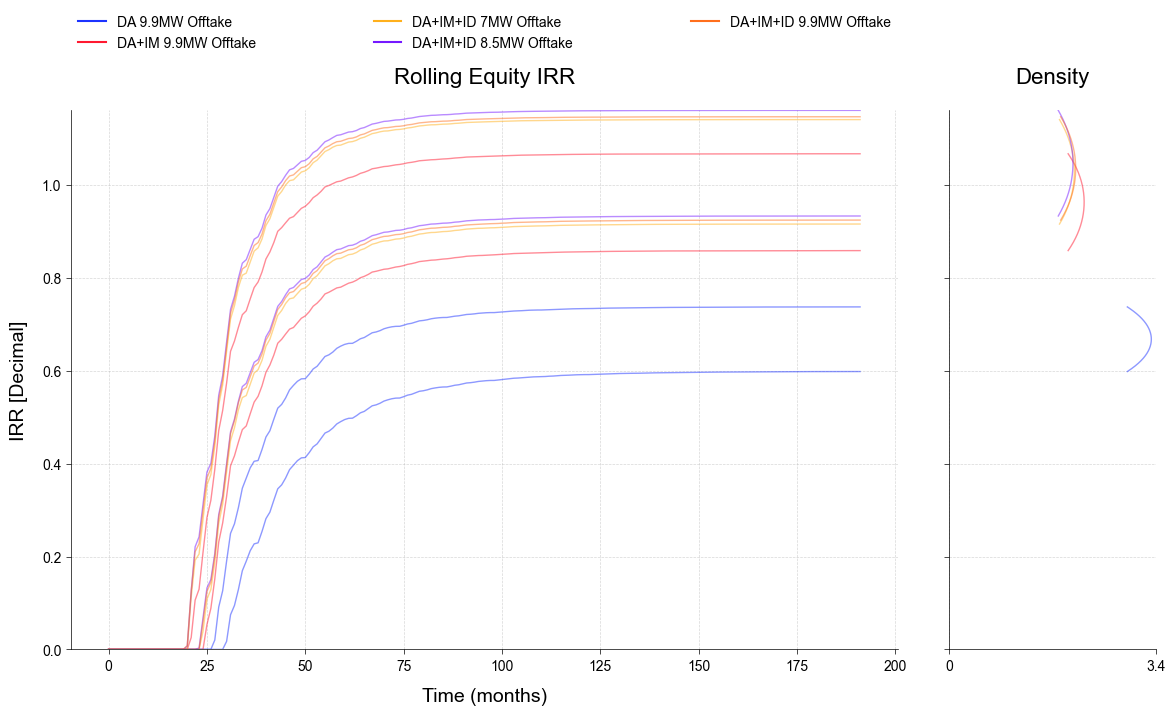

In [154]:
fig, axes = lines(x, o, legend=True, group_by='Case', outcomes_to_show='Rolling_Equity_IRR', density=Density.KDE)

# Set figure size
fig.set_size_inches(14, 7)

# Get axes
ax = fig.get_axes()

# Set style to seaborn whitegrid for a clean look
sns.set_style('whitegrid')

# Update line properties
for axis in ax:
    for line in axis.get_lines():
        line.set_alpha(0.5)  # Slightly less transparent than before
        line.set_linewidth(1)  # Increase line width for better visibility
    axis.margins(y=0)

# Clean up spines and grid lines
for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_linewidth(0.5)
    axis.spines['bottom'].set_linewidth(0.5)
    axis.xaxis.set_tick_params(width=0.5)
    axis.yaxis.set_tick_params(width=0.5)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Light dashed grid lines

# Set titles and labels with larger font size

    ax[0].set_title('Rolling Equity IRR', fontsize=16, pad=20)
    ax[1].set_title('Density', fontsize=16, pad=20)
    ax[0].set_xlabel('Time (months)', fontsize=14, labelpad=10)
    ax[0].set_ylabel('IRR [Decimal]', fontsize=14, labelpad=10)

# Add and style legend
for axis in ax:
    legend = axis.get_legend()
    if legend:
        legend.set_frame_on(False)  # Remove legend frame
        legend.get_frame().set_alpha(0.2)  # Slight transparency

# Remove top and right spines, clean the look
sns.despine()

plt.show()

In [156]:
def plot_irr_boxplot(o, case_series, x_axis_order=None, width=800, height=600):
    import pandas as pd
    import numpy as np
    import plotly.express as px

    # Extract NPV values
    npv_values = np.array(o['Equity_IRR']).astype(float)
    
    # Ensure the lengths match
    if len(npv_values) != len(case_series):
        raise ValueError("Mismatch between the number of values and cases.")
    
    # Create a DataFrame
    data = pd.DataFrame({
        'IRR [Decimal]': npv_values,
        'Scenario': case_series
    })

    # Apply explicit ordering if provided
    if x_axis_order:
        data['Scenario'] = pd.Categorical(data['Scenario'], categories=x_axis_order, ordered=True)

    # Plotting the box plot
    fig = px.box(
        data,
        x='Scenario',
        y='IRR [Decimal]',
        color='Scenario',
        title='Box Plot of Equity IRR per Scenario',
        category_orders={'Scenario': x_axis_order},  # Explicitly set category order in Plotly
        color_discrete_sequence=[
            "#1c33ff", "#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", 
            "#a3ff19", "#19ffe8", "#e819ff", "#a5a7dd", "#565a8c", 
            "#930700", "#2ade72"
        ]
    )
    
    # Update layout with size parameters
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title="Scenario",
        yaxis_title="IRR [Decimal]"
    )
    
    # Show plot
    fig.show()

def plot_npv_boxplot(o, case_series, x_axis_order=None, width=800, height=600):
    import pandas as pd
    import numpy as np
    import plotly.express as px

    # Extract NPV values
    npv_values = np.array(o['Equity_NPV']).astype(float)
    
    # Ensure the lengths match
    if len(npv_values) != len(case_series):
        raise ValueError("Mismatch between the number of values and cases.")
    
    # Create a DataFrame
    data = pd.DataFrame({
        'NPV [EUR]': npv_values,
        'Scenario': case_series
    })

    # Apply explicit ordering if provided
    if x_axis_order:
        data['Scenario'] = pd.Categorical(data['Scenario'], categories=x_axis_order, ordered=True)

    # Plotting the box plot
    fig = px.box(
        data,
        x='Scenario',
        y='NPV [EUR]',
        color='Scenario',
        title='Box Plot of Equity NPV per Scenario',
        category_orders={'Scenario': x_axis_order},  # Explicitly set category order in Plotly
        color_discrete_sequence=[
            "#1c33ff", "#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", 
            "#a3ff19", "#19ffe8", "#e819ff", "#a5a7dd", "#565a8c", 
            "#930700", "#2ade72"
        ]
    )
    
    # Update layout with size parameters
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title="Scenario",
        yaxis_title="NPV [Euro]"
    )
    
    # Show plot
    fig.show()

# Example usage:
x_axis_order = ["DA 9.9MW Offtake", "DA+IM 9.9MW Offtake", "DA+IM+ID 9.9MW Offtake", "DA+IM+ID 7MW Offtake", "DA+IM+ID 8.5MW Offtake", "DA+IM+ID 8.5MW Offtake CBC Contract"]

plot_irr_boxplot(o, x["Case"], x_axis_order=x_axis_order, width=1000, height=700)
plot_npv_boxplot(o, x["Case"], x_axis_order=x_axis_order, width=1000, height=700)

In [211]:
box1.peeling_trajectory_


AttributeError: 

In [200]:
# Create a boolean mask for cases where coverage and density are close to 0.8
tradeoff_data = box1.tradeoff
mask = ((tradeoff_data['coverage'] >= 0.8) & (tradeoff_data['density'] >= 0.8))

# Get the indices of the matching rows
indices = tradeoff_data[mask].index.to_numpy()

# Use the indices with determine_coi
coi = prim_alg.determine_coi(indices)

print(f"Number of cases of interest: {coi}")

AttributeError: 

In [199]:
prim_alg.determine_coi(np.full((2, 1), 0.8))

IndexError: arrays used as indices must be of integer (or boolean) type

In [223]:
# Get the last box limits from the list
last_box_lims = box1.box_lims[-1]

# Get the indices of the observations in the box
indices = box1.yi

# Create the new PrimBox
new_box = prim.PrimBox(prim_alg, last_box_lims, indices)

In [240]:
box1.yi

array([1, 5, 7])

In [241]:
prim_alg.determine_coi([1,5,7])

3

[MainProcess/INFO] column model dropped from analysis because it has only one category


[MainProcess/INFO] 10 points remaining, containing 3 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2


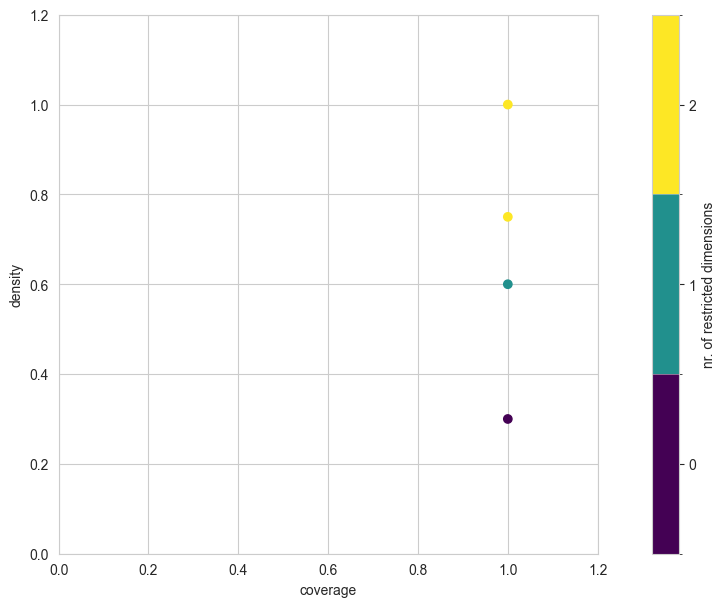

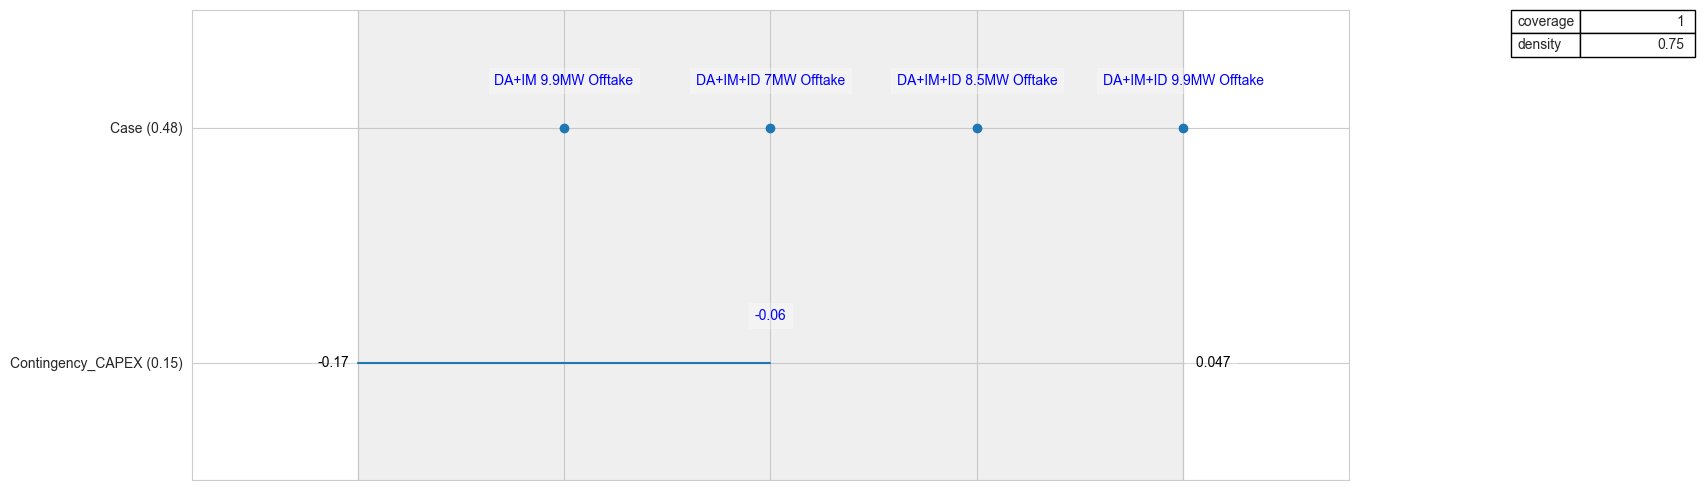

In [237]:
y = (o["Equity_IRR"] > 1.1) 
# Run the PRIM algorithm
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
box1.show_tradeoff()

tradeoff_data = box1.inspect_tradeoff

# # Find the index of the box closest to 0.8 density and coverage
# tradeoff_data['distance_to_0.8'] = ((tradeoff_data['coverage'] - 0.8)**2 + (tradeoff_data['density'] - 0.8)**2)**0.5
# boi = tradeoff_data['distance_to_0.8'].idxmin()

fig = plt.gcf()
fig.set_size_inches(14,7)

# specify box of interest
boi = 2
# box1.inspect(boi)
# box1.inspect(boi, style='graph')

# plt.grid(True)  # Enable gridlines

# plt.show()

# Inspect box with graph
box1.inspect(boi, style='graph')

# Increase figure size if labels overlap (adjust values as needed)
plt.gcf().set_size_inches(17,5)

# Enable gridlines
plt.grid(True)

# Auto-adjust layout to prevent label overlap
plt.tight_layout()

plt.show()

               Feature     Score
0                 Case  0.497697
1  gridcost_volatility  0.029550
2  gasprice_volatility  0.028917
3     Contingency_OPEX  0.024861
4    Contingency_CAPEX  0.016590


C:\Users\AlisyaMustikaa\AppData\Local\Temp\ipykernel_2268\792596157.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




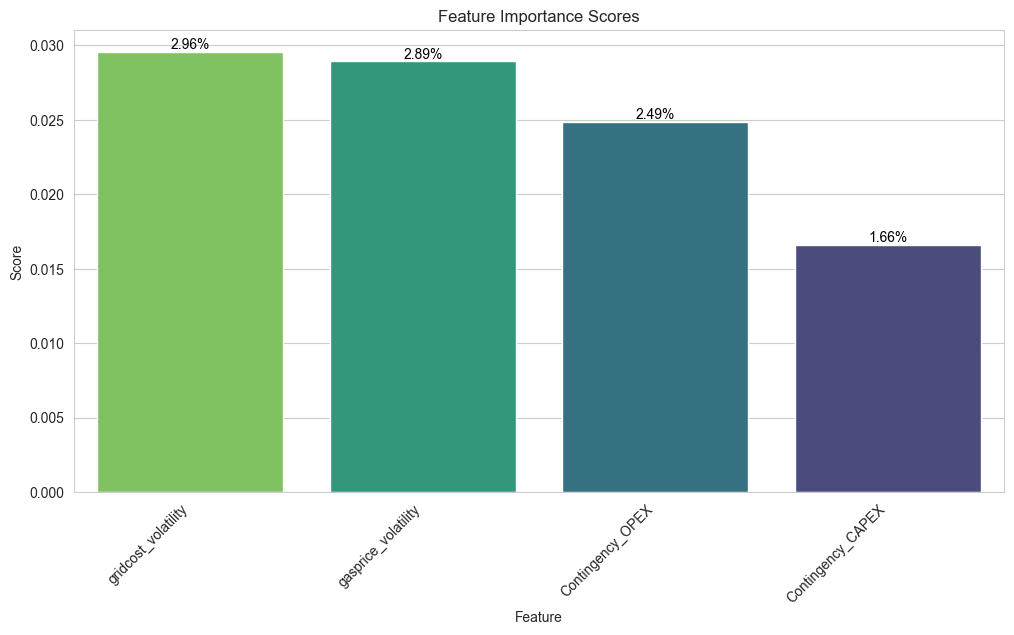

In [174]:
y = o["Equity_NPV"] > 13100000

fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
fs.sort_values(ascending=False, by=1)

import pandas as pd

# Assuming fs is a DataFrame resulting from the feature scoring process
# Sort by the second column (column index 1)
fs = fs.sort_values(ascending=False, by=1)

# Pretty display using pandas styling
fs_sorted = fs.style.background_gradient(cmap="viridis")
fs_sorted

# Assuming fs is a DataFrame resulting from the feature scoring process
# Sort by the second column (column index 1)
fs_sorted = fs.sort_values(ascending=False, by=1)

# Omit the row that has the value for "Policy"
fs_sorted2 = fs_sorted[fs_sorted.index != 'policy']

# Pretty display using pandas styling
styled_fs = fs_sorted2.style.background_gradient(cmap="viridis")

# To display the styled DataFrame
styled_fs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reset the index and drop the unwanted 'index' column (which was previously the 'Case' row)
fs_reset = fs_sorted2.reset_index()

fs_reset.columns = ['Feature', 'Score']

# Remove rows where 'index' (previously 'Case') column is equal to 'Case'
#fs_reset = fs_reset[fs_reset['Feature'] != 'Case']

# Drop the 'index' column as it's not necessary now
#fs_reset = fs_reset.drop(columns=['index'])

# Rename the remaining columns to 'Feature' and 'Score'
fs_reset.columns = ['Feature', 'Score']

# Sort the DataFrame by scores in descending order
fs_sorted = fs_reset.sort_values(by='Score', ascending=False)

# Verify if the 'Case' feature is removed
print(fs_sorted.head())

# Plot with Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Feature', y='Score', data=fs_sorted[fs_sorted["Feature"] != "Case"], palette='viridis_r')

# Add labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}%',  # Format the percentage with 2 decimals
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position the label
                ha='center', va='bottom', fontsize=10, color='black')  # Alignments and styling

# Titles and labels
plt.title('Feature Importance Scores')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Score")
plt.show()

In [ ]:
class DUA:
    def __init__(self, model_file, model_cases, model_uncertainties, n_simulations):
        self.model_file = model_file
        self.model_cases = model_cases
        self.model_uncertainties = model_uncertainties
        self.n_simulations = n_simulations

        self.o = None
        self.x = None

        self.run_model()
        self.plot_rolling_irr()
        self.plot_irr_boxplot()
        self.plot_npv_boxplot()
        self.conditional_analysis()

    def run_model(self):
        # Get the current working directory
        current_directory = os.getcwd()

        # Navigate to the parent directory
        parent_directory = os.path.dirname(current_directory)

        if __name__ == "__main__":
            ema_logging.log_to_stderr(level=ema_logging.INFO)

            model = ExcelModel("Model", wd=parent_directory, model_file="250130 - Multi-Asset Financial Model Version 1.12B Kisuma (2024) - DUA.xlsx")
            model.uncertainties = self.model_uncertainties
            
            model.levers = [
            CategoricalParameter("Case", (self.model_cases)),    						
            ]
            
            model.outcomes = [
                # Standard Metrics
                TimeSeriesOutcome("TIME"),
                ScalarOutcome("MODELCHECK"),
                
                # Debt Metrics
                #TimeSeriesOutcome("DSCR_Tenor"),
                # ScalarOutcome("DSCR_First5Years_Min"),
                # ScalarOutcome("ADSCR_First5Years"),
                #ScalarOutcome("ADSCR_Tenor"),
                #ScalarOutcome("LLCR"),
                #ScalarOutcome("LLCR_Min"),

                # IRR Metrics
                TimeSeriesOutcome("Rolling_Equity_IRR"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
                #ScalarOutcome("Project_IRR_AfterTax"),
                # ScalarOutcome("Project_IRR_BeforeTax"),
                ScalarOutcome("Equity_IRR"),

                # NPV Metrics
                ScalarOutcome("Equity_NPV"),

                # Operational Metrics
                # TimeSeriesOutcome("EBITDA"),
                # ScalarOutcome("EBITDA_Total"),
            ]  

            # name of the sheet
            model.default_sheet = "General Inputs"

            results = perform_experiments(model, self.n_simulations, policies=len(self.model_cases), reporting_interval=None)
            x,o = results

            # Automate reshaping of time series outcomes
            for outcome_name, outcome_value in o.items():
                if isinstance(outcome_value, np.ndarray) and outcome_value.ndim == 3:
                    # Assuming the first dimension is the number of scenarios
                    num_scenarios = outcome_value.shape[0]
                    num_timesteps = np.prod(outcome_value.shape[1:])
                    o[outcome_name] = outcome_value.reshape((num_scenarios, num_timesteps))
                    
                    # Print dimensions for verification
                    print(f"Reshaped {outcome_name} to {o[outcome_name].shape}")

            # Print final reshaped dimensions for verification
            for outcome_name, outcome_value in o.items():
                print(f"Final dimensions of {outcome_name}: {outcome_value.shape}")

            self.x = x
            self.o = o

    def plot_rolling_irr(self):
        x = self.x
        o = self.o

        fig, axes = lines(x, o, legend=True, group_by='Case', outcomes_to_show='Rolling_Equity_IRR', density=Density.KDE)

        # Set figure size
        fig.set_size_inches(14, 7)

        # Get axes
        ax = fig.get_axes()

        # Set style to seaborn whitegrid for a clean look
        sns.set_style('whitegrid')

        # Update line properties
        for axis in ax:
            for line in axis.get_lines():
                line.set_alpha(0.5)  # Slightly less transparent than before
                line.set_linewidth(1)  # Increase line width for better visibility
            axis.margins(y=0)

        # Clean up spines and grid lines
        for axis in ax:
            axis.spines['top'].set_visible(False)
            axis.spines['right'].set_visible(False)
            axis.spines['left'].set_linewidth(0.5)
            axis.spines['bottom'].set_linewidth(0.5)
            axis.xaxis.set_tick_params(width=0.5)
            axis.yaxis.set_tick_params(width=0.5)
            axis.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)  # Light dashed grid lines

        # Set titles and labels with larger font size

            ax[0].set_title('Rolling Equity IRR', fontsize=16, pad=20)
            ax[1].set_title('Density', fontsize=16, pad=20)
            ax[0].set_xlabel('Time (months)', fontsize=14, labelpad=10)
            ax[0].set_ylabel('IRR [Decimal]', fontsize=14, labelpad=10)

        # Add and style legend
        for axis in ax:
            legend = axis.get_legend()
            if legend:
                legend.set_frame_on(False)  # Remove legend frame
                legend.get_frame().set_alpha(0.2)  # Slight transparency

        # Remove top and right spines, clean the look
        sns.despine()

        plt.show()

    def plot_irr_boxplot(self, width=800, height=600):
        o = self.o
        case_series = self.x['Case']
        x_axis_order = list(self.model_cases)

        # Extract NPV values
        npv_values = np.array(o['Equity_IRR']).astype(float)
        
        # Ensure the lengths match
        if len(npv_values) != len(case_series):
            raise ValueError("Mismatch between the number of values and cases.")
        
        # Create a DataFrame
        data = pd.DataFrame({
            'IRR [Decimal]': npv_values,
            'Scenario': case_series
        })

        # Apply explicit ordering if provided
        if x_axis_order:
            data['Scenario'] = pd.Categorical(data['Scenario'], categories=x_axis_order, ordered=True)

        # Plotting the box plot
        fig = px.box(
            data,
            x='Scenario',
            y='IRR [Decimal]',
            color='Scenario',
            title='Box Plot of Equity IRR per Scenario',
            category_orders={'Scenario': x_axis_order},  # Explicitly set category order in Plotly
            color_discrete_sequence=[
                "#1c33ff", "#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", 
                "#a3ff19", "#19ffe8", "#e819ff", "#a5a7dd", "#565a8c", 
                "#930700", "#2ade72"
            ]
        )
        
        # Update layout with size parameters
        fig.update_layout(
            width=width,
            height=height,
            xaxis_title="Scenario",
            yaxis_title="IRR [Decimal]"
        )
        
        # Show plot
        fig.show()

        # Apply explicit ordering if provided
        if x_axis_order:
            data['Scenario'] = pd.Categorical(data['Scenario'], categories=x_axis_order, ordered=True)

        # Group by scenario and calculate Q3 for each case
        q3_values = data.groupby('Scenario')['IRR [Decimal]'].quantile(0.75)

        # Identify the best case dynamically (e.g., the case with the highest Q3)
        best_case = q3_values.idxmax()
        best_case_q3 = q3_values.max()

        print(f"Best case scenario: {best_case}")
        print(f"Q3 (third quartile) of the best-case scenario: {best_case_q3}")

        self.q3_IRR = best_case_q3

    def plot_npv_boxplot(self, width=800, height=600):
        o = self.o
        case_series = self.x['Case']
        x_axis_order = list(self.model_cases)

        # Extract NPV values
        npv_values = np.array(o['Equity_NPV']).astype(float)
        
        # Ensure the lengths match
        if len(npv_values) != len(case_series):
            raise ValueError("Mismatch between the number of values and cases.")
        
        # Create a DataFrame
        data = pd.DataFrame({
            'NPV [EUR]': npv_values,
            'Scenario': case_series
        })

        # Apply explicit ordering if provided
        if x_axis_order:
            data['Scenario'] = pd.Categorical(data['Scenario'], categories=x_axis_order, ordered=True)

        # Plotting the box plot
        fig = px.box(
            data,
            x='Scenario',
            y='NPV [EUR]',
            color='Scenario',
            title='Box Plot of Equity NPV per Scenario',
            category_orders={'Scenario': x_axis_order},  # Explicitly set category order in Plotly
            color_discrete_sequence=[
                "#1c33ff", "#ff1930", "#ffb01c", "#7519ff", "#ff6f1c", 
                "#a3ff19", "#19ffe8", "#e819ff", "#a5a7dd", "#565a8c", 
                "#930700", "#2ade72"
            ]
        )
        
        # Update layout with size parameters
        fig.update_layout(
            width=width,
            height=height,
            xaxis_title="Scenario",
            yaxis_title="NPV [Euro]"
        )
        
        # Show plot
        fig.show()

    def conditional_analysis(self):
        x = self.x
        o = self.o

        # Define the condition for the PRIM algorithm
        y = (o["Equity_IRR"] > self.q3_IRR)

        # Run the PRIM algorithm
        prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
        box1 = prim_alg.find_box()

        # Get the trade-off data
        tradeoff_data = box1.tradeoff_selector()

        # Find the index of the box closest to 0.8 density and coverage
        tradeoff_data['distance_to_0.8'] = ((tradeoff_data['coverage'] - 0.8)**2 + (tradeoff_data['density'] - 0.8)**2)**0.5
        boi = tradeoff_data['distance_to_0.8'].idxmin()

        # Show the trade-off plot
        box1.show_tradeoff()

        # Set the figure size for the trade-off plot
        fig = plt.gcf()
        fig.set_size_inches(14, 7)

        # Inspect the selected box
        box1.inspect(boi, style='graph')

        # Adjust the graph for better visualization
        plt.gcf().set_size_inches(17, 5)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def feature_importance(self):
        o = self.o
        x = self.x

        y = o["Equity_IRR"] > self.q3_IRR

        fs, alg = feature_scoring.get_ex_feature_scores(x, y, mode=RuleInductionType.CLASSIFICATION)
        fs.sort_values(ascending=False, by=1)

        import pandas as pd

        # Assuming fs is a DataFrame resulting from the feature scoring process
        # Sort by the second column (column index 1)
        fs = fs.sort_values(ascending=False, by=1)

        # Pretty display using pandas styling
        fs_sorted = fs.style.background_gradient(cmap="viridis")
        fs_sorted

        # Assuming fs is a DataFrame resulting from the feature scoring process
        # Sort by the second column (column index 1)
        fs_sorted = fs.sort_values(ascending=False, by=1)

        # Omit the row that has the value for "Policy"
        fs_sorted2 = fs_sorted[fs_sorted.index != 'policy']

        # Pretty display using pandas styling
        styled_fs = fs_sorted2.style.background_gradient(cmap="viridis")

        # To display the styled DataFrame
        styled_fs

        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Reset the index and drop the unwanted 'index' column (which was previously the 'Case' row)
        fs_reset = fs_sorted2.reset_index()

        fs_reset.columns = ['Feature', 'Score']

        # Remove rows where 'index' (previously 'Case') column is equal to 'Case'
        #fs_reset = fs_reset[fs_reset['Feature'] != 'Case']

        # Drop the 'index' column as it's not necessary now
        #fs_reset = fs_reset.drop(columns=['index'])

        # Rename the remaining columns to 'Feature' and 'Score'
        fs_reset.columns = ['Feature', 'Score']

        # Sort the DataFrame by scores in descending order
        fs_sorted = fs_reset.sort_values(by='Score', ascending=False)

        # Verify if the 'Case' feature is removed
        print(fs_sorted.head())

        # Plot with Seaborn
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Feature', y='Score', data=fs_sorted[fs_sorted["Feature"] != "Case"], palette='viridis_r')

        # Add labels on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height()*100:.2f}%',  # Format the percentage with 2 decimals
                        (p.get_x() + p.get_width() / 2, p.get_height()),  # Position the label
                        ha='center', va='bottom', fontsize=10, color='black')  # Alignments and styling

        # Titles and labels
        plt.title('Feature Importance Scores')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Feature")
        plt.ylabel("Score")
        plt.show()

[MainProcess/INFO] performing 2 scenarios * 5 policies * 1 model(s) = 10 experiments
100%|██████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]
[MainProcess/INFO] experiments finished


Reshaped TIME to (10, 192)
Reshaped Rolling_Equity_IRR to (10, 192)
Final dimensions of TIME: (10, 192)
Final dimensions of MODELCHECK: (10,)
Final dimensions of Rolling_Equity_IRR: (10, 192)
Final dimensions of Equity_IRR: (10,)
Final dimensions of Equity_NPV: (10,)


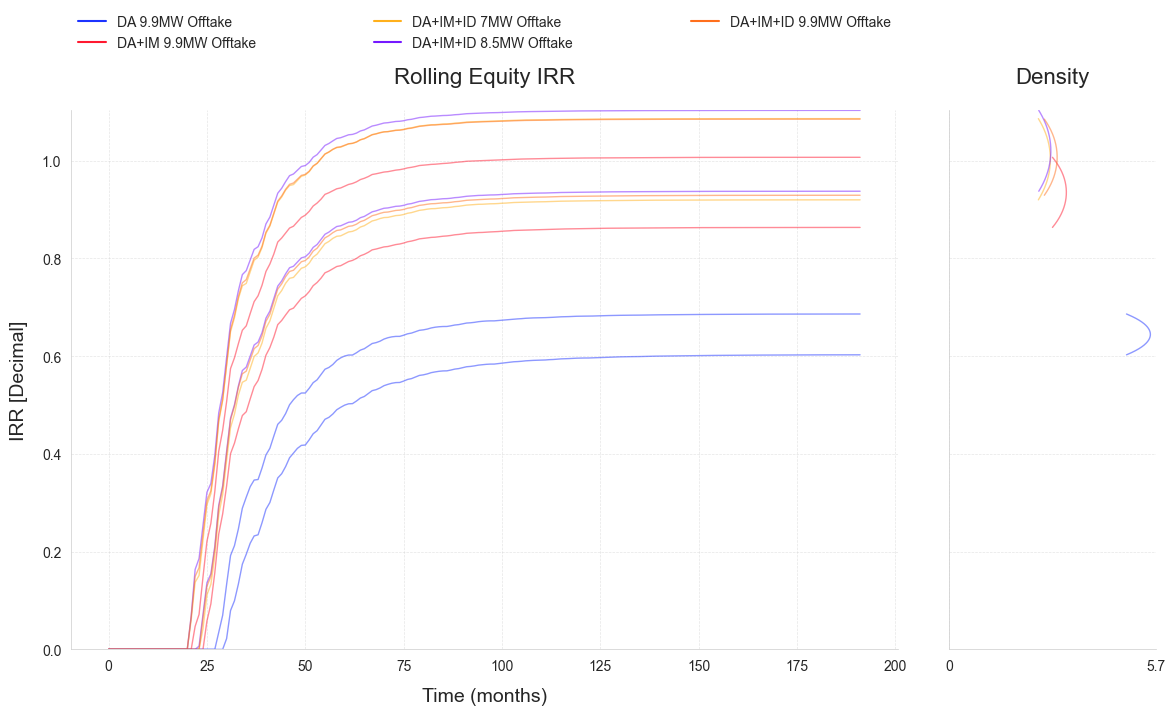

Best case scenario: DA+IM+ID 8.5MW Offtake
Q3 (third quartile) of the best-case scenario: 1.0614176273345945


C:\Users\AlisyaMustikaa\AppData\Local\Temp\ipykernel_2268\2792249253.py:191: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10 points remaining, containing 3 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3, coverage: 1.0, density: 1.0 restricted_dimensions: 2


AttributeError: 

In [173]:
model_file = "250130 - Multi-Asset Financial Model Version 1.12B Kisuma (2024) - DUA.xlsx"
model_cases = "DA 9.9MW Offtake", "DA+IM 9.9MW Offtake", "DA+IM+ID 9.9MW Offtake", "DA+IM+ID 7MW Offtake", "DA+IM+ID 8.5MW Offtake"
model_uncertainties = [
        # CAPEX & OPEX parameters
        RealParameter("Contingency_CAPEX", -0.2, 0.2),
        RealParameter("Contingency_OPEX", -0.2, 0.2),
        # RealParameter("Merchant_Revenue", 150000, 350000),
        # RealParameter("EnecoMRI", 150000, 350000),
        # RealParameter("Land_lease_RE", 100000, 250000),
        # RealParameter("Land_lease_zelf", 300000, 600000),
        # RealParameter("landlease", 475000, 500000),
        # RealParameter("Aandeelhouderschap", 0.05, 0.25),
        # CategoricalParameter("revenuesplitshare", ("0","0.15","0.2")),
        # CategoricalParameter("revenuesplitbound", ("27000000","28000000","29000000", "30000000","31000000","32000000")),
        # CategoricalParameter("Repayment_type_senior", ("Linear", "Balloon")),
        # RealParameter("Interest_rate_senior", 0.04,0.05),
        # RealParameter("Balloon_size_senior", 0.05,0.15),
        # RealParameter("Gearing", 0.5, 0.8),
        # RealParameter("Yearly_revenue_growth", -0.02, 0.02),
        RealParameter("gridcost_volatility", -0.1,0.25),
        RealParameter("gasprice_volatility", -0.1, 0.2),
        # RealParameter("ATR85_Coverage", 0., 1)
    ]

kisuma_DUA = DUA(model_file, model_cases, model_uncertainties, n_simulations=2)

[MainProcess/INFO] performing 1 scenarios * 5 policies * 1 model(s) = 5 experiments
100%|████████████████████████████████████████████| 5/5 [00:20<00:00,  4.13s/it]
[MainProcess/INFO] experiments finished


Reshaped TIME to (5, 192)
Reshaped Model_length to (5, 192)
Reshaped Rolling_Equity_IRR to (5, 192)
Reshaped Cumulative_cash_flow to (5, 192)
Final dimensions of TIME: (5, 192)
Final dimensions of Model_length: (5, 192)
Final dimensions of MODELCHECK: (5,)
Final dimensions of Merchant_revenue: (5,)
Final dimensions of Subsidy: (5,)
Final dimensions of Grid_costs: (5,)
Final dimensions of Energy_tax: (5,)
Final dimensions of Gas_tax: (5,)
Final dimensions of EBITDA_Total: (5,)
Final dimensions of Rolling_Equity_IRR: (5, 192)
Final dimensions of Project_IRR_AfterTax: (5,)
Final dimensions of Project_IRR_BeforeTax: (5,)
Final dimensions of Equity_IRR: (5,)
Final dimensions of WACC: (5,)
Final dimensions of Equity_NPV: (5,)
Final dimensions of CAPEX: (5,)
Final dimensions of Cumulative_cash_flow: (5, 192)
Final dimensions of Payback_period: (5,)


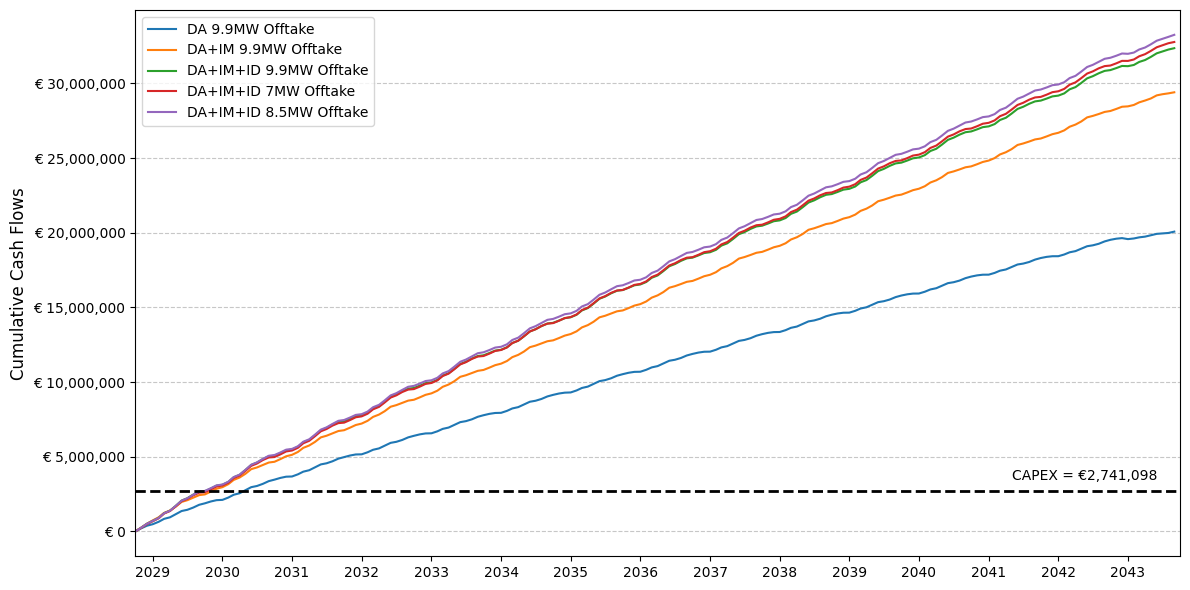

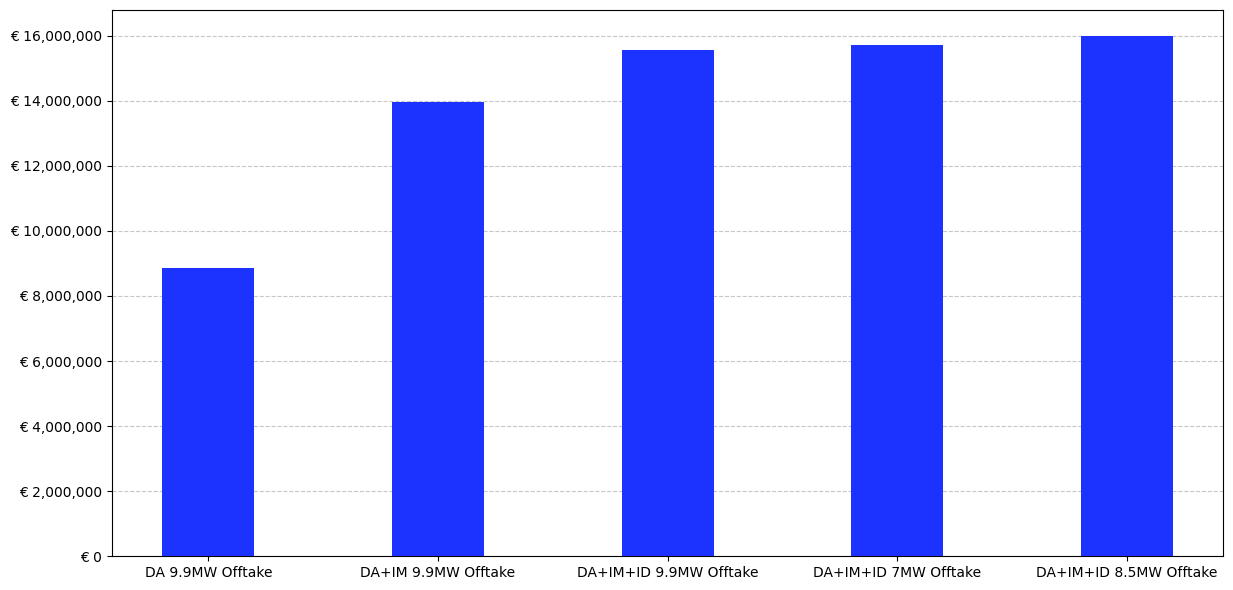

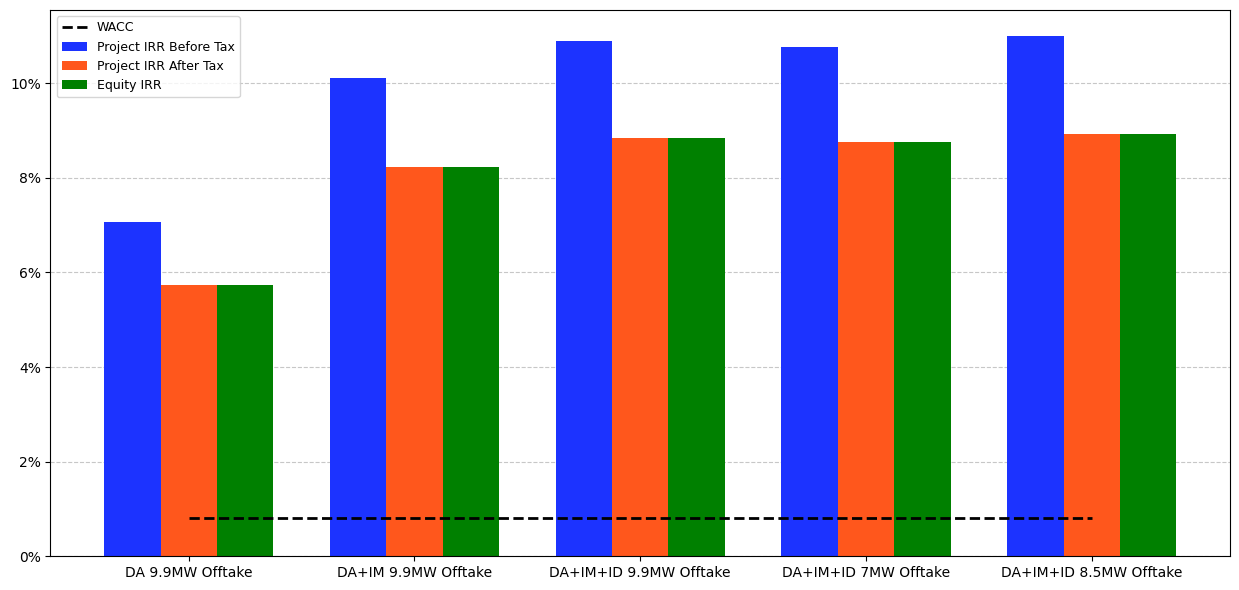

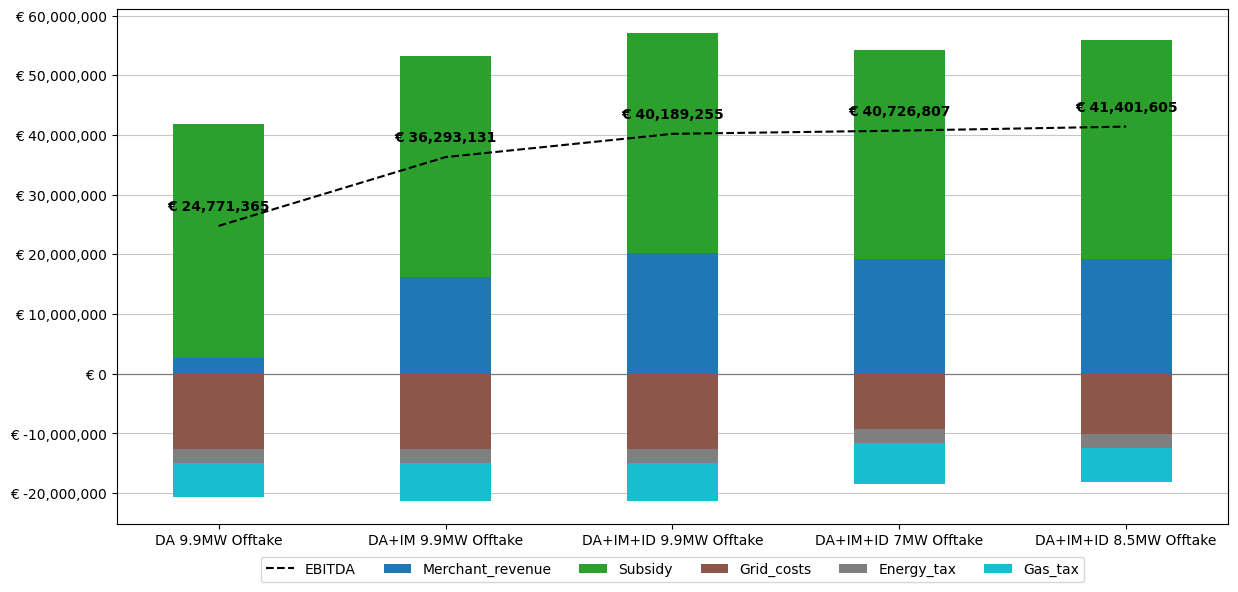

In [151]:
model_file = "250130 - Multi-Asset Financial Model Version 1.12B Kisuma (2024) - DUA.xlsx"
model_cases = "DA 9.9MW Offtake", "DA+IM 9.9MW Offtake", "DA+IM+ID 9.9MW Offtake", "DA+IM+ID 7MW Offtake", "DA+IM+ID 8.5MW Offtake"
model_start = '2027-11-01'
model_length = 16*12

kisuma = BuCa(model_file, model_cases, model_start, model_length)

In [150]:
##TO-DO: If e-boiler == yes, then e-boiler metrics == on 
class BuCa:
    def __init__(self, model_file, model_cases, model_start, model_length):
        self.model_file = model_file
        self.model_cases = model_cases
        self.model_start = model_start
        self.model_length = model_length
        self.df_timeseries = None
        self.df = None
        self.x = None
        self.o = None

        self.run_model()
        self.store_results()
        self.plot_pbp() 
        self.plot_npv()
        self.plot_irr()
        self.plot_ebitda()
        self.output_results()

    def run_model(self):
        # Get the current working directory
        current_directory = os.getcwd()

        # Navigate to the parent directory
        parent_directory = os.path.dirname(current_directory)

        if __name__ == "__main__":
            ema_logging.log_to_stderr(level=ema_logging.INFO)

            model = ExcelModel("BuCa", wd=parent_directory, model_file=self.model_file)
            
            model.levers = [
            CategoricalParameter("Case", (self.model_cases)),    						
            ]
            
            model.outcomes = [
                # Standard Metrics
                TimeSeriesOutcome("TIME"),
                TimeSeriesOutcome("Model_length"),
                ScalarOutcome("MODELCHECK"),
                
                # Debt Metrics
                #TimeSeriesOutcome("DSCR_Tenor"),
                # ScalarOutcome("DSCR_First5Years_Min"),
                # ScalarOutcome("ADSCR_First5Years"),
                #ScalarOutcome("ADSCR_Tenor"),
                #ScalarOutcome("LLCR"),
                #ScalarOutcome("LLCR_Min"),

                #EBITDA_Breakdown
                ScalarOutcome("Merchant_revenue"),
                ScalarOutcome("Subsidy"),
                ScalarOutcome("Grid_costs"),
                ScalarOutcome("Energy_tax"),
                ScalarOutcome("Gas_tax"),
                ScalarOutcome("EBITDA_Total"),


                # IRR Metrics
                TimeSeriesOutcome("Rolling_Equity_IRR"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
                #TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
                ScalarOutcome("Project_IRR_AfterTax"),
                ScalarOutcome("Project_IRR_BeforeTax"),
                ScalarOutcome("Equity_IRR"),
                ScalarOutcome("WACC"),

                # NPV Metrics
                ScalarOutcome("Equity_NPV"),

                #E-boiler Metrics
                ScalarOutcome("CAPEX"),
                TimeSeriesOutcome("Cumulative_cash_flow"),
                ScalarOutcome("Payback_period"),

                # Operational Metrics
                # TimeSeriesOutcome("EBITDA"),
            ]  

            # name of the sheet
            model.default_sheet = "General Inputs"

            results = perform_experiments(model, 0, policies=len(self.model_cases), reporting_interval=None)
            x,o = results

            # Automate reshaping of time series outcomes
            for outcome_name, outcome_value in o.items():
                if isinstance(outcome_value, np.ndarray) and outcome_value.ndim == 3:
                    # Assuming the first dimension is the number of scenarios
                    num_scenarios = outcome_value.shape[0]
                    num_timesteps = np.prod(outcome_value.shape[1:])
                    o[outcome_name] = outcome_value.reshape((num_scenarios, num_timesteps))
                    
                    # Print dimensions for verification
                    print(f"Reshaped {outcome_name} to {o[outcome_name].shape}")

            # Print final reshaped dimensions for verification
            for outcome_name, outcome_value in o.items():
                print(f"Final dimensions of {outcome_name}: {outcome_value.shape}")

            self.x = x
            self.o = o

    def store_results(self):
        cumulative_cash_flows = self.o['Cumulative_cash_flow']

        # Create a DataFrame from the time series data
        df_timeseries = pd.DataFrame(cumulative_cash_flows).T

        df_timeseries.columns = self.x['Case'].astype(str)

        # Convert to datetime and remove timezone
        df_timeseries['datetime'] = pd.date_range(start=self.model_start, periods=self.model_length, freq='MS')

        # Define the desired order of categories
        desired_order = list(self.model_cases)

        # Ensure the columns of df_timeseries match the desired order
        df_timeseries = df_timeseries[['datetime'] + desired_order]

        self.df_timeseries = df_timeseries

        ##----------------------------------------------------------------

        scalar_outcomes = [key for key, value in self.o.items() if value.shape[1:] == ()]

        df = pd.DataFrame({key: self.o[key] for key in scalar_outcomes})
        df["Case"] = self.x['Case'].astype(str)

        # Define the desired order of categories
        desired_order = list(self.model_cases)

        # Reorder the Case column
        df['Case'] = pd.Categorical(df['Case'], categories=desired_order, ordered=True)

        # Sort the DataFrame by the new order (optional, for consistent plotting)
        df = df.sort_values('Case')

        self.df = df

    def plot_pbp(self):
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot each column in df_timeseries (excluding 'datetime')
        for column in self.df_timeseries.columns:
            if column != 'datetime':
                ax.plot(self.df_timeseries['datetime'][11:-1], self.df_timeseries[column][11:-1], label=column)

        # Plot CAPEX as a horizontal line
        capex_value = self.o["CAPEX"][0]  # Assuming CAPEX is a single number
        ax.axhline(y=capex_value, label='_nolegend_', color='black', linestyle='--', linewidth=2)

        # Add a label for the CAPEX line above the line on the right edge
        ax.text(
            self.df_timeseries['datetime'].iloc[-30],  # x-coordinate (right edge of the plot)
            capex_value+500000,                        # y-coordinate (CAPEX value)
            f'CAPEX = €{capex_value:,.0f}',    # Label text
            color='black',                      # Text color
            fontsize=10,                        # Font size
            ha='left',                          # Horizontal alignment
            va='bottom'                         # Vertical alignment
        )

        # Add labels, title, and legend
        ax.set_ylabel('Cumulative Cash Flows', fontsize=12)
        ax.legend(fontsize=10)

        # Format y-axis with thousands comma separator and euro sign
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Format x-axis to show every year
        ax.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display the year

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)
        plt.xlim(self.df_timeseries['datetime'][11], self.df_timeseries['datetime'].iloc[-1])  # Set x-axis limits

        # Add gridlines
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_npv(self):
        # Create the figure and axis
        num_cases = len(self.df)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))

        # Create a bar chart with thinner bars and updated color
        bars = plt.bar(self.df['Case'], self.df['Equity_NPV'], color='#1c33ff', width=0.4)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)

        # Format y-axis with a comma separator for thousands
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Add gridlines for y-axis
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Redraw the bars to ensure they appear on top of the grid
        for bar in bars:
            bar.set_zorder(3)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_irr(self):
        df = self.df
        # Assuming 'df' contains the columns 'Case', 'Project_IRR_BeforeTax', 'Project_IRR_AfterTax', 'Equity_IRR', and 'WACC'
        categories = df['Case']
        values_before_tax = df['Project_IRR_BeforeTax'] * 10  # Multiply by 10
        values_after_tax = df['Project_IRR_AfterTax'] * 10    # Multiply by 10
        values_equity_irr = df['Equity_IRR'] * 10             # Multiply by 10
        values_wacc = df['WACC'] * 10                         # Multiply by 10

        # Define the positions for the bars
        a = np.arange(len(categories))  # the label locations
        width = 0.25  # the width of the bars

        # Create the figure and axis
        num_cases = len(df)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))

        # Plot each group of bars
        bars1 = ax.bar(a - width, values_before_tax, width, label='Project IRR Before Tax', color='#1c33ff', zorder=2)
        bars2 = ax.bar(a, values_after_tax, width, label='Project IRR After Tax', color='#ff571c', zorder=2)
        bars3 = ax.bar(a + width, values_equity_irr, width, label='Equity IRR', color='green', zorder=2)

        # Plot WACC as a dashed black line without markers
        ax.plot(a, values_wacc, label='WACC', color='black', linestyle='--', linewidth=2, zorder=3)

        # Add labels, title, and legend
        ax.set_xticks(a)
        ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=10)
        ax.legend(fontsize=9)

        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda a, _: f'{a:,.0f}%'))

        # Add gridlines for y-axis and ensure they are in the background
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

    def plot_ebitda(self):
        # Define the parameters to include in the stacked bar chart
        parameters = ['Merchant_revenue', 'Subsidy', 'Grid_costs', 'Energy_tax', 'Gas_tax']

        # Filter the DataFrame to include only the cases and the specified parameters
        df_filtered = self.df[['Case'] + parameters + ['EBITDA_Total']]

        # Set the 'Case' column as the index for easier plotting
        df_filtered.set_index('Case', inplace=True)

        # Dynamically set the figure width based on the number of cases
        num_cases = len(df_filtered)
        fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(fig_width, 6))  # Height is fixed, width is dynamic

        # Plot the stacked bar chart with thinner bars
        df_filtered[parameters].plot(kind='bar', stacked=True, ax=ax, colormap='tab10', zorder=2, width=0.4)

        # Add a line graph for EBITDA_Total
        ax.plot(df_filtered.index, df_filtered['EBITDA_Total'], color='black', linestyle='--', label='EBITDA', zorder=3)

        # Add data labels for the EBITDA_Total line
        for i, value in enumerate(df_filtered['EBITDA_Total']):
            ax.text(
                i, value + 0.05 * max(df_filtered['EBITDA_Total']),  # Slightly above the line
                f'€ {value:,.0f}',  # Format as currency
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
            )

        # Add gridlines and highlight the gridline at 0
        ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)  # Regular gridlines
        ax.axhline(0, color='black', linewidth=0.8, linestyle='-', zorder=1)  # Highlighted gridline at 0

        # Remove x-axis title
        ax.set_xlabel('')  # Removes the x-axis title

        # Move the legend to the bottom in a straight line
        ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)

        # Format y-axis with thousands comma separator and euro sign
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=0, ha='center', fontsize=10)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()
        

    def output_results(self):
        # Create a new Excel workbook
        wb = Workbook()

        # Add df to the first sheet
        sheet1 = wb.active
        sheet1.title = "df"
        for row in dataframe_to_rows(self.df, index=True, header=True):
            sheet1.append(row)

        # Add df_timeseries to a new sheet
        sheet2 = wb.create_sheet(title="df_timeseries")
        for row in dataframe_to_rows(self.df_timeseries, index=True, header=True):
            sheet2.append(row)

        # Save the workbook
        wb.save("output.xlsx")


In [118]:
# Get the current working directory
current_directory = os.getcwd()

# Navigate to the parent directory
parent_directory = os.path.dirname(current_directory)

if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)

    model = ExcelModel("Zeijerveen", wd=parent_directory, model_file="250130 - Multi-Asset Financial Model Version 1.12B Kisuma (2024) - DUA.xlsx")
    # model.uncertainties = [
    #     # CAPEX & OPEX parameters
    #     RealParameter("Contingency_CAPEX", 0, 0.1),
    #     # RealParameter("Contingency_OPEX", -0.2, 0.2),
    #     # RealParameter("Merchant_Revenue", 150000, 350000),
    #     # RealParameter("EnecoMRI", 150000, 350000),
    #     # RealParameter("Land_lease_RE", 100000, 250000),
    #     # RealParameter("Land_lease_zelf", 300000, 600000),
    #     # RealParameter("landlease", 475000, 500000),
    #     # RealParameter("Aandeelhouderschap", 0.05, 0.25),
    #     # CategoricalParameter("revenuesplitshare", ("0","0.15","0.2")),
    #     # CategoricalParameter("revenuesplitbound", ("27000000","28000000","29000000", "30000000","31000000","32000000")),
    #     # CategoricalParameter("Repayment_type_senior", ("Linear", "Balloon")),
    #     # RealParameter("Interest_rate_senior", 0.04,0.05),
    #     # RealParameter("Balloon_size_senior", 0.05,0.15),
    #     # RealParameter("Gearing", 0.5, 0.8),
    #     # RealParameter("Yearly_revenue_growth", -0.02, 0.02),
    #     # RealParameter("gridcost_volatility", -0.1,0.25),
    #     # RealParameter("gasprice_volatility", -0.1, 0.2),
    #     # RealParameter("ATR85_Coverage", 0., 1)
    # ]
    
    model.levers = [
       CategoricalParameter("Case", ("DA 9.9MW Offtake", "DA+IM 9.9MW Offtake", "DA+IM+ID 9.9MW Offtake", "DA+IM+ID 7MW Offtake", "DA+IM+ID 8.5MW Offtake")),    						
    ]
    
    model.outcomes = [
        # Standard Metrics
        TimeSeriesOutcome("TIME"),
        TimeSeriesOutcome("Model_length"),
        ScalarOutcome("MODELCHECK"),
        
        # Debt Metrics
        #TimeSeriesOutcome("DSCR_Tenor"),
        # ScalarOutcome("DSCR_First5Years_Min"),
        # ScalarOutcome("ADSCR_First5Years"),
        #ScalarOutcome("ADSCR_Tenor"),
        #ScalarOutcome("LLCR"),
        #ScalarOutcome("LLCR_Min"),

        #EBITDA_Breakdown
        ScalarOutcome("Merchant_revenue"),
        ScalarOutcome("Subsidy"),
        ScalarOutcome("Grid_costs"),
        ScalarOutcome("Energy_tax"),
        ScalarOutcome("Gas_tax"),
        ScalarOutcome("EBITDA_Total"),


        # IRR Metrics
        TimeSeriesOutcome("Rolling_Equity_IRR"),
        #TimeSeriesOutcome("Rolling_ProjectIRR_AfterTax"),
        #TimeSeriesOutcome("Rolling_ProjectIRR_BeforeTax"),
        ScalarOutcome("Project_IRR_AfterTax"),
        ScalarOutcome("Project_IRR_BeforeTax"),
        ScalarOutcome("Equity_IRR"),
        ScalarOutcome("WACC"),

        # NPV Metrics
        ScalarOutcome("Equity_NPV"),

        #E-boiler Metrics
        ScalarOutcome("CAPEX"),
        TimeSeriesOutcome("Cumulative_cash_flow"),
        ScalarOutcome("Payback_period"),

        # Operational Metrics
        # TimeSeriesOutcome("EBITDA"),
    ]  

    # name of the sheet
    model.default_sheet = "General Inputs"

    results = perform_experiments(model, 0, policies=5, reporting_interval=None)
    x,o = results

    # Automate reshaping of time series outcomes
    for outcome_name, outcome_value in o.items():
        if isinstance(outcome_value, np.ndarray) and outcome_value.ndim == 3:
            # Assuming the first dimension is the number of scenarios
            num_scenarios = outcome_value.shape[0]
            num_timesteps = np.prod(outcome_value.shape[1:])
            o[outcome_name] = outcome_value.reshape((num_scenarios, num_timesteps))
            
            # Print dimensions for verification
            print(f"Reshaped {outcome_name} to {o[outcome_name].shape}")

    # Print final reshaped dimensions for verification
    for outcome_name, outcome_value in o.items():
        print(f"Final dimensions of {outcome_name}: {outcome_value.shape}")

[MainProcess/INFO] performing 1 scenarios * 5 policies * 1 model(s) = 5 experiments
  0%|                                                    | 0/5 [00:00<?, ?it/s]

[MainProcess/INFO] performing experiments sequentially
100%|████████████████████████████████████████████| 5/5 [01:17<00:00, 15.56s/it]
[MainProcess/INFO] experiments finished


Reshaped TIME to (5, 192)
Reshaped Model_length to (5, 192)
Reshaped Rolling_Equity_IRR to (5, 192)
Reshaped Cumulative_cash_flow to (5, 192)
Final dimensions of TIME: (5, 192)
Final dimensions of Model_length: (5, 192)
Final dimensions of MODELCHECK: (5,)
Final dimensions of Merchant_revenue: (5,)
Final dimensions of Subsidy: (5,)
Final dimensions of Grid_costs: (5,)
Final dimensions of Energy_tax: (5,)
Final dimensions of Gas_tax: (5,)
Final dimensions of EBITDA_Total: (5,)
Final dimensions of Rolling_Equity_IRR: (5, 192)
Final dimensions of Project_IRR_AfterTax: (5,)
Final dimensions of Project_IRR_BeforeTax: (5,)
Final dimensions of Equity_IRR: (5,)
Final dimensions of WACC: (5,)
Final dimensions of Equity_NPV: (5,)
Final dimensions of CAPEX: (5,)
Final dimensions of Cumulative_cash_flow: (5, 192)
Final dimensions of Payback_period: (5,)


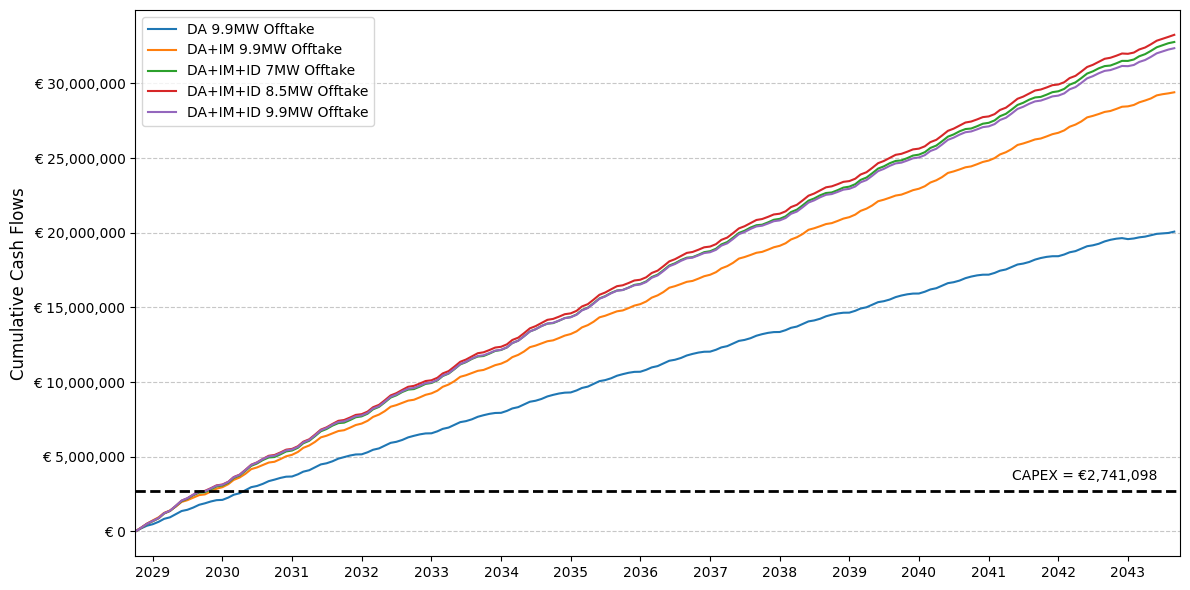

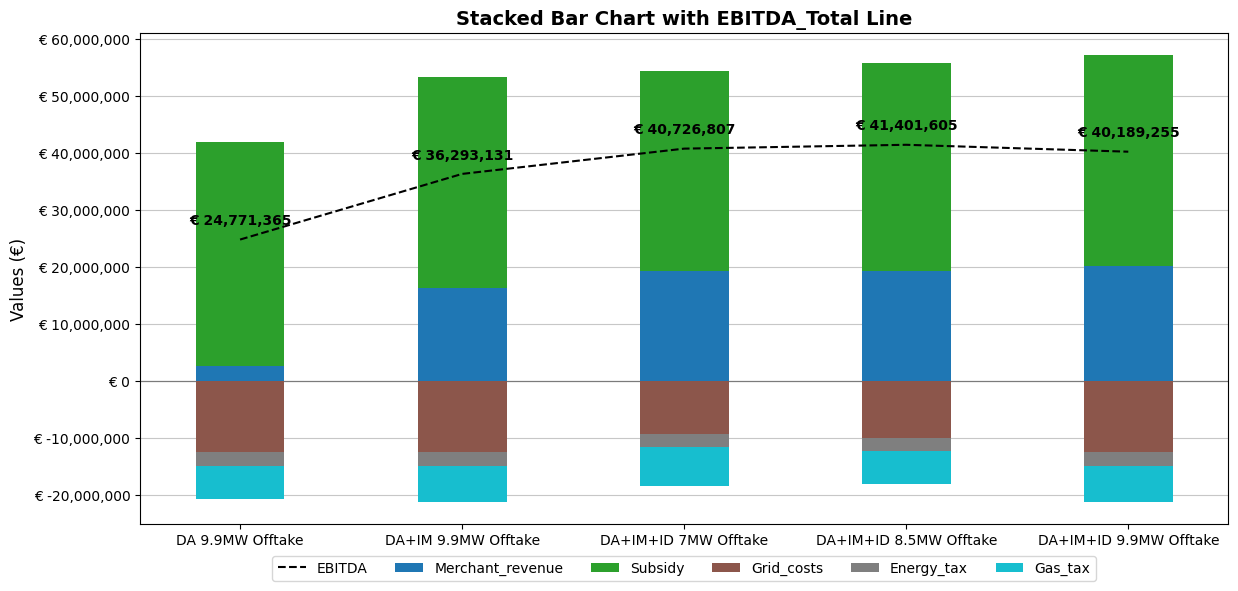

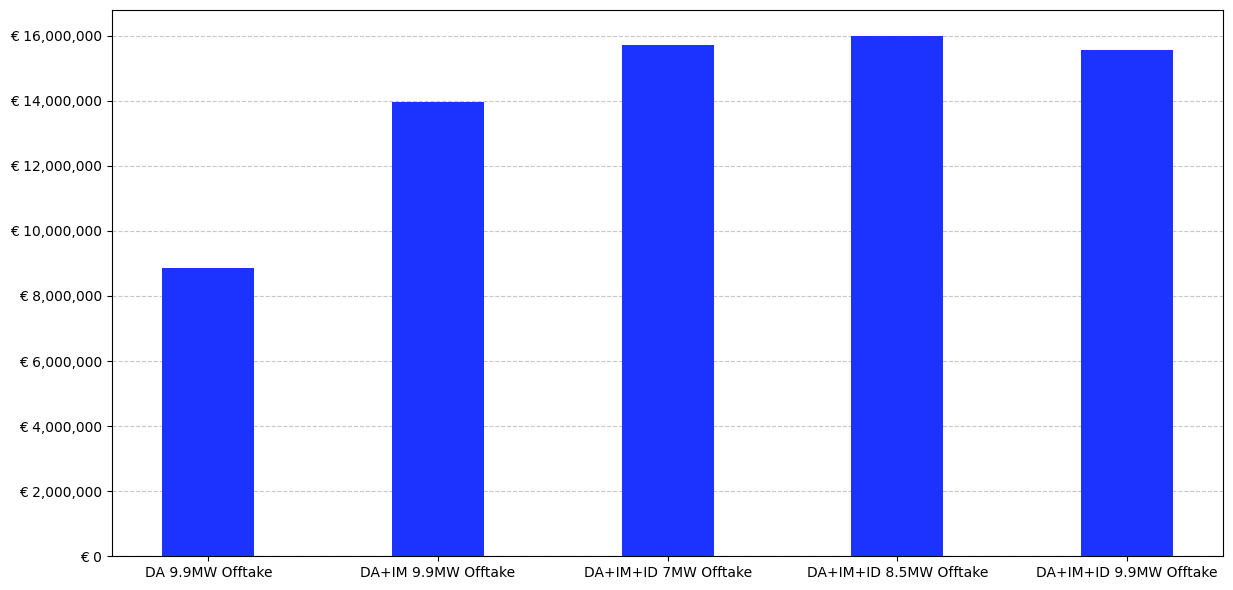

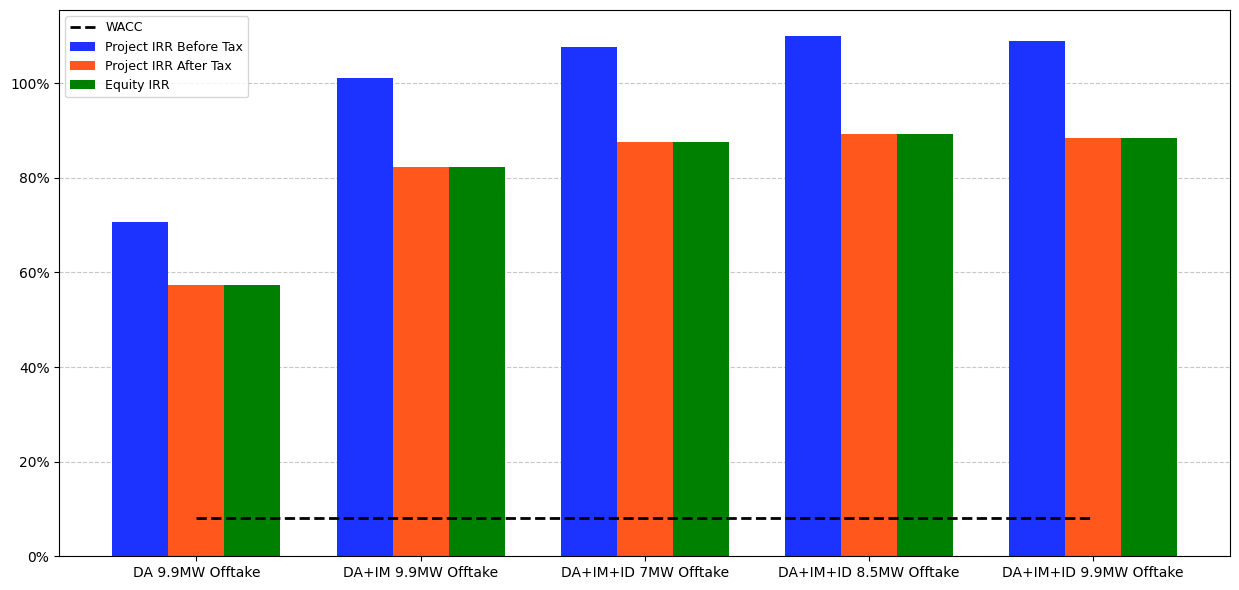

In [141]:
cumulative_cash_flows = o['Cumulative_cash_flow']

# Create a DataFrame from the time series data
df_timeseries = pd.DataFrame(cumulative_cash_flows).T

df_timeseries.columns = x['Case'].astype(str)

# Convert to datetime and remove timezone
df_timeseries['datetime'] = pd.date_range(start='2027-11-01', periods=16*12, freq='MS')

# Define the desired order of categories
desired_order = ['DA 9.9MW Offtake', 'DA+IM 9.9MW Offtake', 'DA+IM+ID 7MW Offtake', 'DA+IM+ID 8.5MW Offtake', 'DA+IM+ID 9.9MW Offtake']

# Ensure the columns of df_timeseries match the desired order
df_timeseries = df_timeseries[['datetime'] + desired_order]

##--------------------------------------------------------------------

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates


# Assuming 'df_timeseries' contains the time series data and 'o["CAPEX"]' contains the CAPEX value
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each column in df_timeseries (excluding 'datetime')
for column in df_timeseries.columns:
    if column != 'datetime':
        ax.plot(df_timeseries['datetime'][11:-1], df_timeseries[column][11:-1], label=column)
        
        # # Add a label for each line at the last data point
        # ax.text(
        #     df_timeseries['datetime'].iloc[-30],  # x-coordinate (second-to-last datetime to avoid clipping)
        #     df_timeseries[column].iloc[-2],     # y-coordinate (value of the last data point)
        #     column,                             # Label text (column name)
        #     fontsize=10,                        # Font size
        #     color='black',  # Match the label color to the line color
        #     ha='left',                          # Horizontal alignment
        #     va='bottom'                         # Vertical alignment
        # )

# Plot CAPEX as a horizontal line
capex_value = o["CAPEX"][0]  # Assuming CAPEX is a single number
ax.axhline(y=capex_value, label='_nolegend_', color='black', linestyle='--', linewidth=2)

# Add a label for the CAPEX line above the line on the right edge
ax.text(
    df_timeseries['datetime'].iloc[-30],  # x-coordinate (right edge of the plot)
    capex_value+500000,                        # y-coordinate (CAPEX value)
    f'CAPEX = €{capex_value:,.0f}',    # Label text
    color='black',                      # Text color
    fontsize=10,                        # Font size
    ha='left',                          # Horizontal alignment
    va='bottom'                         # Vertical alignment
)

# Add labels, title, and legend
ax.set_ylabel('Cumulative Cash Flows', fontsize=12)
ax.legend(fontsize=10)

# Format y-axis with thousands comma separator and euro sign
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

# Format x-axis to show every year
ax.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks to display the year

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.xlim(df_timeseries['datetime'][11], df_timeseries['datetime'].iloc[-1])  # Set x-axis limits

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

##--------------------------------------------------------------------

scalar_outcomes = [key for key, value in o.items() if value.shape[1:] == ()]

df = pd.DataFrame({key: o[key] for key in scalar_outcomes})
df["Case"] = x['Case'].astype(str)

# Define the desired order of categories
desired_order = ['DA 9.9MW Offtake', 'DA+IM 9.9MW Offtake', 'DA+IM+ID 7MW Offtake', 'DA+IM+ID 8.5MW Offtake', 'DA+IM+ID 9.9MW Offtake']

# Reorder the Case column
df['Case'] = pd.Categorical(df['Case'], categories=desired_order, ordered=True)

# Sort the DataFrame by the new order (optional, for consistent plotting)
df = df.sort_values('Case')

##---

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Define the parameters to include in the stacked bar chart
parameters = ['Merchant_revenue', 'Subsidy', 'Grid_costs', 'Energy_tax', 'Gas_tax']

# Filter the DataFrame to include only the cases and the specified parameters
df_filtered = df[['Case'] + parameters + ['EBITDA_Total']]

# Set the 'Case' column as the index for easier plotting
df_filtered.set_index('Case', inplace=True)

# Dynamically set the figure width based on the number of cases
num_cases = len(df_filtered)
fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

# Create the figure and axis
fig, ax = plt.subplots(figsize=(fig_width, 6))  # Height is fixed, width is dynamic

# Plot the stacked bar chart with thinner bars
df_filtered[parameters].plot(kind='bar', stacked=True, ax=ax, colormap='tab10', zorder=2, width=0.4)

# Add a line graph for EBITDA_Total
ax.plot(df_filtered.index, df_filtered['EBITDA_Total'], color='black', linestyle='--', label='EBITDA', zorder=3)

# Add data labels for the EBITDA_Total line
for i, value in enumerate(df_filtered['EBITDA_Total']):
    ax.text(
        i, value + 0.05 * max(df_filtered['EBITDA_Total']),  # Slightly above the line
        f'€ {value:,.0f}',  # Format as currency
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
    )

# Add gridlines and highlight the gridline at 0
ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)  # Regular gridlines
ax.axhline(0, color='black', linewidth=0.8, linestyle='-', zorder=1)  # Highlighted gridline at 0

# Remove x-axis title
ax.set_xlabel('')  # Removes the x-axis title

# Add y-axis label and title
ax.set_ylabel('Values (€)', fontsize=12)
ax.set_title('Stacked Bar Chart with EBITDA_Total Line', fontsize=14, fontweight='bold')

# Move the legend to the bottom in a straight line
ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6)

# Format y-axis with thousands comma separator and euro sign
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


##--

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Create the figure and axis
num_cases = len(df)
fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

# Create the figure and axis
fig, ax = plt.subplots(figsize=(fig_width, 6))

# Create a bar chart with thinner bars and updated color
bars = plt.bar(df['Case'], df['Equity_NPV'], color='#1c33ff', width=0.4)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center', fontsize=10)

# Format y-axis with a comma separator for thousands
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'€ {x:,.0f}'))

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Redraw the bars to ensure they appear on top of the grid
for bar in bars:
    bar.set_zorder(3)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

##--

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' contains the columns 'Case', 'Project_IRR_BeforeTax', 'Project_IRR_AfterTax', 'Equity_IRR', and 'WACC'
categories = df['Case']
values_before_tax = df['Project_IRR_BeforeTax'] * 100  # Multiply by 10
values_after_tax = df['Project_IRR_AfterTax'] * 100    # Multiply by 10
values_equity_irr = df['Equity_IRR'] * 100             # Multiply by 10
values_wacc = df['WACC'] * 100                         # Multiply by 10

# Define the positions for the bars
a = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

# Create the figure and axis
num_cases = len(df)
fig_width = max(10, num_cases * 2.5)  # Set a minimum width of 10 and scale with the number of cases

# Create the figure and axis
fig, ax = plt.subplots(figsize=(fig_width, 6))

# Plot each group of bars
bars1 = ax.bar(a - width, values_before_tax, width, label='Project IRR Before Tax', color='#1c33ff', zorder=2)
bars2 = ax.bar(a, values_after_tax, width, label='Project IRR After Tax', color='#ff571c', zorder=2)
bars3 = ax.bar(a + width, values_equity_irr, width, label='Equity IRR', color='green', zorder=2)

# Plot WACC as a dashed black line without markers
ax.plot(a, values_wacc, label='WACC', color='black', linestyle='--', linewidth=2, zorder=3)

# Add labels, title, and legend
ax.set_xticks(a)
ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=10)
ax.legend(fontsize=9)

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda a, _: f'{a:,.0f}%'))

# Add gridlines for y-axis and ensure they are in the background
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
##put to plotly format

In [129]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Create a new Excel workbook
wb = Workbook()

# Add df to the first sheet
sheet1 = wb.active
sheet1.title = "df"
for row in dataframe_to_rows(df, index=True, header=True):
    sheet1.append(row)

# Add df_timeseries to a new sheet
sheet2 = wb.create_sheet(title="df_timeseries")
for row in dataframe_to_rows(df_timeseries, index=True, header=True):
    sheet2.append(row)

# Save the workbook
wb.save("output.xlsx")